In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/MyDrive/ADM-HW4/

/gdrive/MyDrive/ADM-HW4


## 2. Clustering

### Data 

#### Description and exploration

The dataset [*Amazon Fine Food Reviews*](https://www.kaggle.com/snap/amazon-fine-food-reviews) we are working on contains the plain text of the reviews about fine food on Amazon - gathered from Oct 1999 to Oct 2012 - and the metadata associated with them. Specifically, the dataset has the following columns:  

- Id -> identifies each review
- ProductId -> identifies each product
- UserId -> identifies the author of the review
- ProfileName -> the username of the author; may be not present
- HelpfulnessNumerator -> number of users that considered the review helpful
- HelpfulnessDenominator -> number of users who judged the review helpful or not helpful
- Score -> score given to the product reviewed 
- Time -> timestamp of the review, in UNIX format
- Summary -> brief summary of the content of the review
- Text -> plain text of the review

First and foremost, we explore the dataset. For handling the data, we wrote a class `DataHandler` which can be found in the file `scripts/data_handling.py`; see the [Appendix](#appendix) for more information about the classes used.

In [3]:
from scripts.data_handling import HandlerCreator

data_handler = HandlerCreator.create_data_handler(test=False)

In [4]:
data_handler.load_dataset(dataset_path='data/Reviews.csv')

In [ ]:
data_handler.get_dataset().head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data_handler.get_dataset().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
data_handler.get_dataset().isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

As we can see, there are few data missing in the dataset. Since we are asked to focus on the plain text of the review, from now on we drop all the columns but **Text** and we work only on the review content:

In [ ]:
dataset = data_handler.get_dataset().Text
data_handler.set_dataset(dataset)

In [ ]:
data_handler.get_dataset().head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [ ]:
dataset.iloc[233937]

Text    mini size little small enjoyment prefer big gu...
Name: 233937, dtype: object

### Data pre-processing

Before applying K-means on the dataset, it is worth to pre-process the text, in order to denoise the data and reduce the number of features. Thi last point is crutial, since the K-means algorithm suffers of the curse of dimensionality. 

The first step, as usual, is to get rid of the few informative words from the text. To do this, we write the following function:

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag



def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = dict.fromkeys(stopwords.words('english'))
    parts_of_speech = {'N':'n', 'V':'v', 'J':'a'}
    words_list = pos_tag(word_tokenize(text))
    result_words = []
    for word, pos in words_list:
        if (word.lower() not in stop_words) and word.isalpha() and (pos[0] in parts_of_speech):
            result_words.append(lemmatizer.lemmatize(word.lower(), pos=parts_of_speech[pos[0]]))
    return ' '.join(result_words)

Specifically, the function above transforms into lower case the words in the text, gets rid of the words that contain non alphabetical characters, lemmatizes and tags the words and filters the text according to part of speech tag assigned to each word. Since we are trying to reduce the dimensionality of the feature set as much as possible with the minimum information loss, we filter out all the words that are not nouns, verbs or adjectives; indeed, we reckon that pronouns, articles, adverbs and so on give us few or no information about the review's topic.

In [ ]:
dataset = data_handler.get_dataset()
dataset['Text'] = dataset.Text.apply(clean_text)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
dtypes: object(1)
memory usage: 4.3+ MB


Text cleaning left us with two blank rows, which have indexes 233938 and 453668. Checking them in the original dataset, we found that text of these reviews is not written in English, but in Russian. So, we decided to drop these two rows:

In [ ]:
dataset[dataset.Text == '']

,Text
233938,
453668,


In [ ]:
dataset = dataset[dataset.Text != '']

Since the text pre-processing takes several minutes to be done, we save the pre-processed text in a new file, so that we can load fastly then: 

In [ ]:
dataset.to_csv('data/Reviews_processed.csv', index=False)

In [4]:
data_handler.load_dataset('data/Reviews_processed.csv')
dataset = data_handler.get_dataset()

In [ ]:
dataset.head()

,Text
0,buy several vitality can food product find goo...
1,product arrive label jumbo salted peanut peanu...
2,confection century light pillowy citrus gelati...
3,look secret ingredient robitussin believe find...
4,great taffy great price wide assortment yummy ...


At this point, it is possible to compute the document-term matrix. Following the results and the conclusions in [[1]](#r:1), [[2]](#r:2), we decided to represent the reviews using a TF-IDF representation instead of a binary representation; indeed, to discriminate the topic of each review, it is worth to consider which words are the most informative and which are almost noise, i.e. which are present in many reviews and the are not discriminative.

We leverage the `TfidfVectorizer` object of the `sklearn` library, which we make use of under the hood of `DataHandler.get_docterm_mat()`.

As a first step for noise reduction, we specify in the constructor of `TfidfVectorizer` the parameter `max_df`, which allows to filter out the words that appear in a fraction of the documents grater than the one specified; doing this, we discard the words that are stop words in our soecific corpus of documents. 

Then, with the parameter `min_df` we also discard those words that are very rare and thus that may alter too much the vector representation of the documents in the space. After many tries, we found that the optimal values for these parameters are ???.

In [5]:
docterm_mat = data_handler.get_docterm_matrix()

In [6]:
docterm_mat.shape[1] # number of features, that is number of words in the vocabulary

50711

As we can see, the number of features, that is the number of components of the vectors that represent the documents, is still huge.

To dramatically reduce the number of features, we apply the SVD method to the document-term matrix. We start trying with a number of components equal to 100, as suggested, and increasing this number until at least the 60% of the initial variance is retained. As pointed out in [[3]](#r:3), K-means is known to work better on normalized features; then we pipeline the SVD method with a normalization, as in the official `sklearn` documentation. 

In [7]:
from sklearn.decomposition import TruncatedSVD # for features reduction
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


#svd = TruncatedSVD(n_components=100)
#normalizer = Normalizer(copy=False)
#lsa = make_pipeline(svd, normalizer)
#reduced = lsa.fit_transform(docterm_mat)

In [8]:
import numpy as np


#np.cumsum(svd.explained_variance_ratio_)

Since our goal is estimate the minimum number of components that retain at least the 60% of the variance, we write the function below:

In [9]:
from matplotlib import pyplot as plt
from tqdm import tqdm

def estimate_components(docterm_mat, start_n, end_n, step=100):
    components_variance = {}
    fig = plt.figure(figsize=(16, 10))
    for n_components in tqdm(range(start_n, end_n, step)):
        svd = TruncatedSVD(n_components=n_components)
        svd.fit_transform(docterm_mat)
        components_variance[n_components] = round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100
        del svd
    plt.plot(list(components_variance.keys()), list(components_variance.values()))
    plt.xlabel('Number of components')
    plt.ylabel('Variance')
    plt.show()

In [ ]:
estimate_components(docterm_mat, 700, 1200)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [09:57<00:00, 298.63s/it]


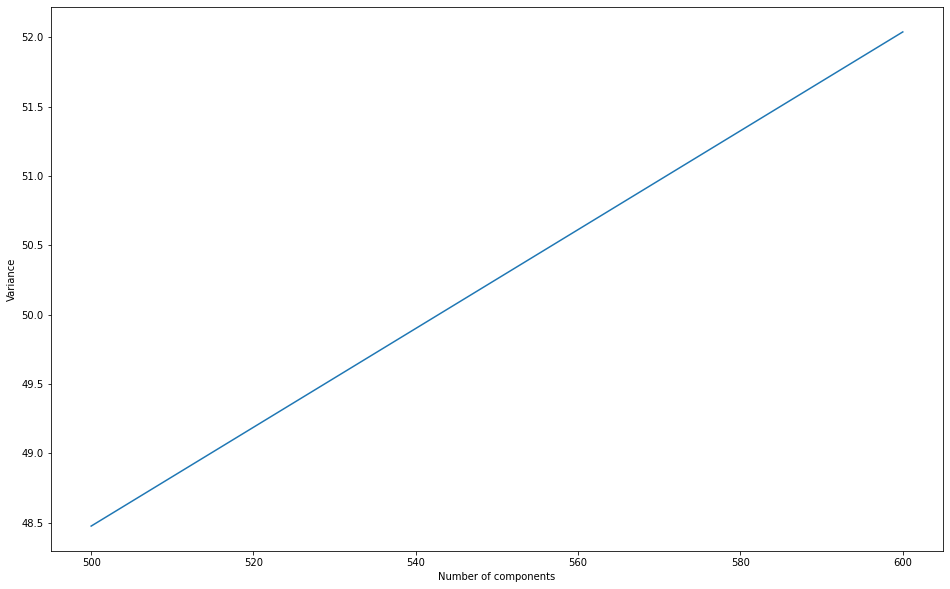

In [ ]:
estimate_components(docterm_mat, 500, 700)

100%|██████████| 3/3 [03:06<00:00, 62.05s/it]


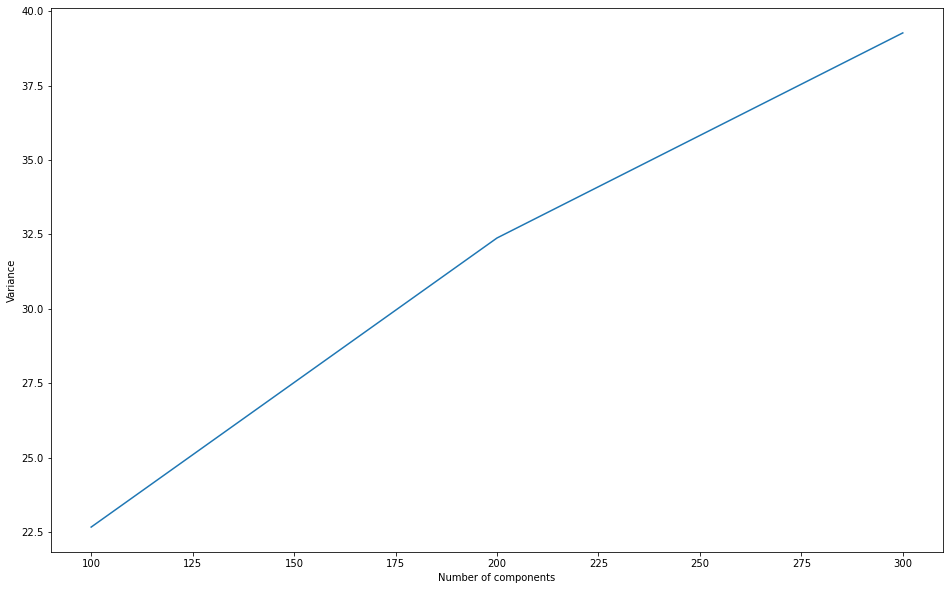

In [ ]:
estimate_components(docterm_mat, 100, 400)

100%|██████████| 10/10 [09:24<00:00, 56.41s/it]


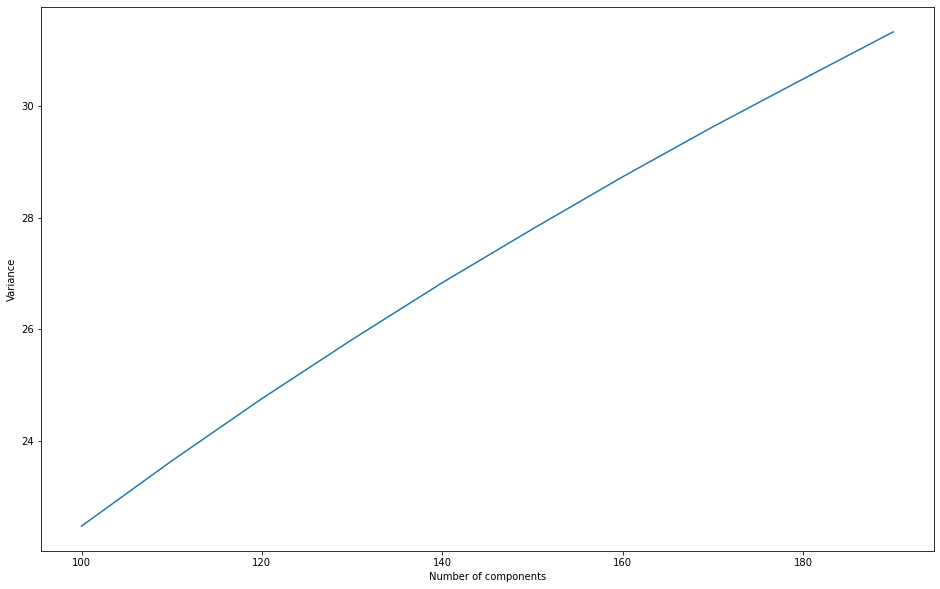

In [ ]:
estimate_components(docterm_mat, 100, 200, 10)

Finally, we save the reduced document-matrix into our `data_handler` object and then we try to apply K-means on these data.

In [ ]:
data_handler.set_docterm_mat(reduced)

### K-means

In [ ]:
# importing the libraries
import numpy as np
import random
from random import randint

In [ ]:
# k : total number of the clusters
def random_centers(k, matrix):
    copy_matrix = np.copy(matrix)
    # matrix for cluster centroids
    center_matrix = np.zeros((k, len(matrix[0])))
    
    # randomly choosing k cluster centers without replacement
    for i in range(k):
        new_center_index = random.randint(0, copy_matrix.shape[0]-1)
        center_matrix[i,:] = copy_matrix[new_center_index, :]
        copy_matrix = np.delete(copy_matrix, new_center_index, 0 )
    return center_matrix

def compute_centroids(cluster_dictionary, matrix, k):
    
    cluster_dict_copy = cluster_dictionary.copy()
    
    # computes the new centroid values
    for i in range(len(cluster_dictionary.keys())):
        cluster_dict_copy[i] = np.array([cluster_dict_copy[i]])
        cluster_dict_copy[i] = np.mean(cluster_dict_copy[i][0], axis=0)
    
    new_center_matrix = np.zeros((k, len(matrix[0])))
    for i in range(len(cluster_dict_copy.keys())):
        new_center_matrix[i] = cluster_dict_copy[i]
        
    return new_center_matrix

def assignment_to_centroids(matrix, center_matrix, k):
    
    # cluster_dict key corresponds to index of clusters, values correspond to elements that belong to the cluster 
    cluster_dict = {}
    for i in range(k):
        cluster_dict[i] = []
        
    for element in matrix:
        min_dist_value  = np.linalg.norm(element - center_matrix[0])
        cluster_index = 0
        for i in range(1, k):
            new_dist = np.linalg.norm(element - center_matrix[i])
            if min_dist_value > new_dist:
                min_dist_value = new_dist
                cluster_index = i
        cluster_dict[cluster_index].append(element)
    
    return cluster_dict

        
        
def k_means(k, matrix):
    
    center_matrix = random_centers(k, matrix)
    cluster_dict  =assignment_to_centroids(matrix, center_matrix, k)
    
    while np.array_equal(center_matrix, compute_centroids(cluster_dict, matrix, k))==False:
        center_matrix = compute_centroids(cluster_dict, matrix, k)
        cluster_dict  = assignment_to_centroids(matrix, center_matrix, k)
    return cluster_dict, center_matrix


In [ ]:
cluster_dict, center_matrix = k_means(4, matrix)

In [ ]:
m = np.array(([2,2,2],[3,3,3],[4,4,4],[10,10,10],[12,12,12],[8,8,8]))

In [ ]:
m

In [ ]:
cluster_dict, center_matrix = k_means(3, m)

In [ ]:
cluster_dict

In [ ]:
center_matrix

## Appendix

<span id='appendix'></span>

## References

<div id='r:1'>[1] V. K. Singh, N. Tiwari and S. Garg, "Document Clustering Using K-Means, Heuristic K-Means and Fuzzy C-Means," 2011 International Conference on Computational Intelligence and Communication Networks, Gwalior, 2011, pp. 297-301, doi: 10.1109/CICN.2011.62.</div><br>

<div id='r:2'>[2] Anna Huang, "Similarity Measures for Text Document Clustering", NZCSRSC 2008, April 2008, Christchurch, New Zeland, doi: 10.1.1.332.4480.</div>